In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import warnings

warnings.filterwarnings(
    "ignore",
    message="plotting functions contained within `_documentation_utils` are intended for nemos's documentation.",
    category=UserWarning,
)

:::{admonition} Download
:class: important render-all

This notebook can be downloaded as **{nb-download}`04_place_cells.ipynb`**. See the button at the top right to download as markdown or pdf.
:::

# Analyzing hippocampal place cells with Pynapple and NeMoS

<div class="render-all">
    
In this tutorial we will review more advanced applications of pynapple; tuning curves, signal processing, and decoding; as well as fitting GLMs to the data using NeMoS. We'll apply these methods to demonstrate and visualize some well-known physiological properties of hippocampal activity, specifically phase presession of place cells and sequential coordination of place cell activity during theta oscillations.

This notebook is separated into 5 Parts:
1. Data wrangling
2. 1D neural tuning and model fitting
3. Signal processing
4. 2D neural tuning and model fitting
5. Neural decoding

</div>

In [2]:
import workshop_utils
# imports
import math
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import scipy as sp
import seaborn as sns
import tqdm
import pynapple as nap

# necessary for animation
import nemos as nmo
plt.style.use(nmo.styles.plot_style)

# configure pynapple to ignore conversion warning
nap.nap_config.suppress_conversion_warnings = True

## Part 1: Data wrangling
### Fetching the data

<div class="render-all">  
    
The data set we'll be looking at is from the manuscript [Diversity in neural firing dynamics supports both rigid and learned hippocampal sequences](https://www.science.org/doi/10.1126/science.aad1935). In this study, the authors collected electrophisiology data in rats across multiple sites in layer CA1 of hippocampus to extract the LFP alongside spiking activity of many simultaneous pyramidal units. In each recording session, data were collected while the rats explored a novel environment (a linear or circular track), as well as during sleep before and after exploration. In our following analyses, we'll focus on the exploration period of a single rat and recording session.

The full dataset for this study can be accessed on [DANDI](https://dandiarchive.org/dandiset/000044/0.210812.1516). Since the file size of a recording session can be large from the LFP saved for each recorded channel, we'll use a smaller file that contains the spiking activity and the LFP from a single, representative channel, which is hosted on [OSF](https://osf.io/2dfvp). This smaller file, like the original data, is saved as an [NWB](https://www.nwb.org) file.

If you ran the workshop setup script, you should have this file downloaded already. If not, the function we'll use to fetch it will download it for you. This function is called `fetch_data`, and can be imported from the `workshop_utils` module. This function will give us the file path to where the data is stored. We can then use the pynapple function `load_file` to load in the data, which is able to handle the NWB file type.

</div>

In [3]:
# fetch file path
path = workshop_utils.fetch_data("Achilles_10252013_EEG.nwb")
# load data with pynapple
data = nap.load_file(path)
print(data)

Achilles_10252013_EEG
┍━━━━━━━━━━━━━┯━━━━━━━━━━━━━┑
│ Keys        │ Type        │
┝━━━━━━━━━━━━━┿━━━━━━━━━━━━━┥
│ units       │ TsGroup     │
│ rem         │ IntervalSet │
│ nrem        │ IntervalSet │
│ forward_ep  │ IntervalSet │
│ eeg         │ TsdFrame    │
│ theta_phase │ Tsd         │
│ position    │ Tsd         │
┕━━━━━━━━━━━━━┷━━━━━━━━━━━━━┙


<div class="render-all">  
    
This returns a dictionary of pynapple objects that have been extracted from the NWB file. Let's explore each of these objects.

</div>

:::{admonition} Note
:class: note render-all
We will ignore the object `theta_phase` because we will be computing this ourselves later on in the exercise.
:::


#### units

<div class="render-all">  
    
The `units` field is a [`TsGroup`](https://pynapple.org/generated/pynapple.TsGroup.html#pynapple.TsGroup): a collection of [`Ts`](https://pynapple.org/generated/pynapple.Ts.html#pynapple.Ts) objects containing the spike times of each unit, where the "Index" is the unit number or key. Each unit has the following metadata:
- **rate**: computed by pynapple, is the average firing rate of the neuron across all recorded time points.
- **location**, **shank**, and **cell_type**: variables saved and imported from the original data set.

</div>

In [4]:
data["units"]

Index    rate     location    shank    cell_type
-------  -------  ----------  -------  -----------
1        1.56775  ca1         1        pE
2        9.12029  ca1         1        pI
6        0.14618  ca1         1        pE
7        1.40307  ca1         1        pE
9        0.22848  ca1         1        pE
11       0.4157   ca1         1        pE
12       1.57063  ca1         1        pE
...      ...      ...         ...      ...
266      0.6839   ca1         13       pE
267      3.0145   ca1         13       pI
268      0.86567  ca1         13       pE
269      0.28607  ca1         13       pE
270      0.30931  ca1         13       pE
271      0.35912  ca1         13       pE
272      0.62102  ca1         13       pE

<div class="render-all">  

We can access the spike times of a single unit by indexing the `TsGroup` by its unit number. For example, to access the spike times of unit 1:

</div>

In [5]:
data["units"][1]

Time (s)
12683.7723
12688.18085
12691.3421
12691.62475
12691.77515
12695.471
12700.2699
...
25536.359
25539.8976
25539.9318
25545.21125
25545.21885
25545.22585
25545.2324
shape: 20173

#### rem, nrem, and forward_ep

<div class="render-all">  

The next three objects; `rem`, `nrem`, and `forward_ep`; are all [`IntervalSet`](https://pynapple.org/generated/pynapple.IntervalSet.html#pynapple.IntervalSet) objects containing time windows of REM sleep, nREM sleep, and forward runs down the linear maze, respectively. 

</div>

In [6]:
data["rem"]

  index    start    end
      0    13747  13934
      1    15963  15991
      2    16035  16214
      3    22521  22573
shape: (4, 2), time unit: sec.

In [7]:
data["nrem"]

  index    start    end
      0    12892  13746
      1    13971  15963
      2    15991  16034
      3    16241  16565
      4    16837  16874
      5    17059  18076
      6    21350  21399
      7    22068  22520
      8    22635  22745
      9    24326  24419
     10    24953  25547
shape: (11, 2), time unit: sec.

In [8]:
data["forward_ep"]

index    start            end
0        18193.598802655  18197.489989104
1        18198.437185805  18201.30437582
2        18240.625838885  18243.083430326
3        18273.95692281   18276.414514252
4        18315.940776603  18318.244768579
5        18347.377467126  18347.761465788
6        18350.193457319  18350.500656249
...      ...              ...
77       19848.786638518  19856.133812932
78       19903.903246576  19904.056846041
79       19954.693469701  19956.587863104
80       19979.422983581  19987.794154429
81       20050.155537258  20052.664328521
82       20072.504259429  20080.465831703
83       20123.217682821  20123.396882197
shape: (84, 2), time unit: sec.

<div class="render-all"> 

All intervals in `forward_ep` occur in the middle of the session, while `rem` and `nrem` both contain sleep epochs that occur before and after exploration. 
    
The following plot demonstrates how each of these labelled epochs are organized across the session.

</div>

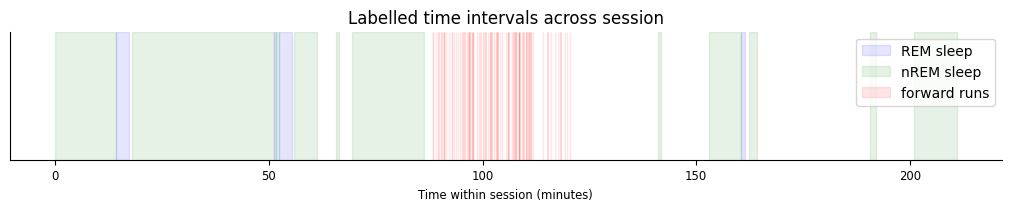

In [9]:
t_start = data["nrem"].start[0]
fig,ax = plt.subplots(figsize=(10,2), constrained_layout=True)
sp1 = [ax.axvspan((iset.start[0]-t_start)/60, (iset.end[0]-t_start)/60, color="blue", alpha=0.1) for iset in data["rem"]];
sp2 = [ax.axvspan((iset.start[0]-t_start)/60, (iset.end[0]-t_start)/60, color="green", alpha=0.1) for iset in data["nrem"]];
sp3 = [ax.axvspan((iset.start[0]-t_start)/60, (iset.end[0]-t_start)/60, color="red", alpha=0.1) for iset in data["forward_ep"]];
ax.set(xlabel="Time within session (minutes)", title="Labelled time intervals across session", yticks=[])
ax.legend([sp1[0],sp2[0],sp3[0]], ["REM sleep","nREM sleep","forward runs"]);

#### eeg

<div class="render-all">  

The `eeg` object is a [`TsdFrame`](https://pynapple.org/generated/pynapple.TsdFrame.html#pynapple.TsdFrame) containing an LFP voltage trace for a single representative channel in CA1.

</div>

In [10]:
data["eeg"]

Time (s)       1
----------  ----
12679.5     -258
12679.5008  -341
12679.5016  -355
12679.5024  -379
12679.5032  -364
12679.504   -406
12679.5048  -508
...
25546.9696  2035
25546.9704  2021
25546.9712  2023
25546.972   1906
25546.9728  1848
25546.9736  1862
25546.9744  1976
dtype: int16, shape: (16084344, 1)

<div class="render-all">  

Despite having a single column, this [`TsdFrame`](https://pynapple.org/generated/pynapple.TsdFrame.html#pynapple.TsdFrame) is still a 2D object. We can represent this as a 1D `Tsd` by indexing into the first column.

</div>

In [11]:
data["eeg"][:,0]

Time (s)
----------  ----
12679.5     -258
12679.5008  -341
12679.5016  -355
12679.5024  -379
12679.5032  -364
12679.504   -406
12679.5048  -508
...
25546.9696  2035
25546.9704  2021
25546.9712  2023
25546.972   1906
25546.9728  1848
25546.9736  1862
25546.9744  1976
dtype: int16, shape: (16084344,)

#### position

<div class="render-all">  

The final object, `position`, is a [`Tsd`](https://pynapple.org/generated/pynapple.Tsd.html#pynapple.Tsd) containing the linearized position of the animal, in centimeters, recorded during the exploration window.

</div>

In [12]:
data["position"]

Time (s)
---------------  ---
18079.5          nan
18079.525599911  nan
18079.551199822  nan
18079.576799733  nan
18079.602399643  nan
18079.627999554  nan
18079.653599465  nan
...
20146.820800624  nan
20146.846400535  nan
20146.872000446  nan
20146.897600357  nan
20146.923200267  nan
20146.948800178  nan
20146.974400089  nan
dtype: float64, shape: (80762,)

<div class="render-all">  

Positions that are not defined, i.e. when the animal is at rest, are filled with `NaN`.

This object additionally contains a [`time_support`](https://pynapple.org/generated/pynapple.Tsd.html#id1) attribute, which gives the time interval during which positions are recorded (including points recorded as `NaN`).

</div>

In [13]:
data["position"].time_support

  index    start    end
      0  18079.5  20147
shape: (1, 2), time unit: sec.

<div class="render-all">  

Let's visualize the first 300 seconds of position data and overlay `forward_ep` intervals.

</div>

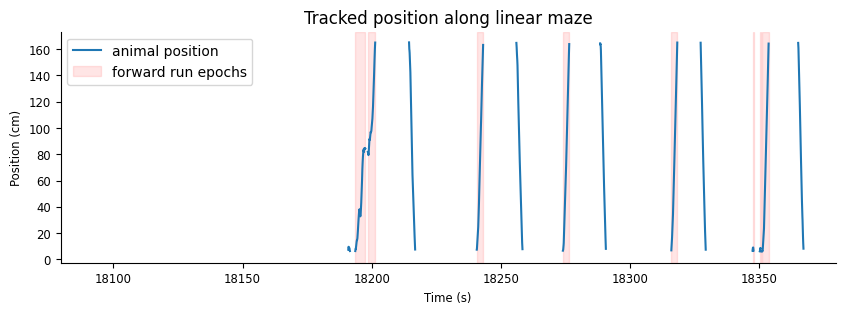

In [14]:
pos_start = data["position"].time_support.start[0]
fig, ax = plt.subplots(figsize=(10,3))
l1 = ax.plot(data["position"])
l2 = [ax.axvspan(iset.start[0], iset.end[0], color="red", alpha=0.1) for iset in data["forward_ep"]];
ax.set(xlim=[pos_start,pos_start+300], ylabel="Position (cm)", xlabel="Time (s)", title="Tracked position along linear maze")
ax.legend([l1[0], l2[0]], ["animal position", "forward run epochs"])

<div class="render-all"> 

This plot confirms that positions are only recorded while the animal is moving along the track. Additionally, it is clear that the intervals in `forward_ep` capture only perios when the animal's position is increasing, during forward runs.

We'll save out the following variables that we'll need throughout the notebook.

</div>

In [15]:
position = data["position"]
lfp = data["eeg"][:,0]
spikes = data["units"]
forward_ep = data["forward_ep"]

### Restricting the data, computing speed, and visualization

<div class="render-all"> 

For the following exercises, we'll only focus on periods labeled as forward runs aloong the linear track. We can extract this information using the interval set `forward_ep`.

</div>

#### 1.1 Restrict `position` to `forward_ep` and confirm that there are no `nan` values in the restricted data set.

<div class="render-user">
```{code-cell} ipython3
# restrict position and check for nans
position = 
```
</div>

In [16]:
position = position.restrict(forward_ep)
np.any(np.isnan(position))

np.False_

<div class="render-all">

We also want the speed of the animal during forward runs. We can get this using the pynapple object method [`derivative`](https://pynapple.org/generated/pynapple.Tsd.derivative.html). Conveniently, this will account for discontinuous intervals either in the time support, or by inputting the optional argument `ep`, the intervals over which you want to compute the derivative.

Note, however, that the output of the derivative function is *velocity*. For the following analyses, we only care about the magnitude, or *speed*; therefore, we'll need to take the absolute value of the output to get our variable of interest.

</div>

#### 1.2 Calculate velocity using the [`derivative`](https://pynapple.org/generated/pynapple.Tsd.derivative.html) method on position during forward runs. Use `np.abs` to convert the velocity into speed.

<div class="render-user">
```{code-cell} ipython3
# calculate speed
speed =
```
</div>

In [17]:
speed = np.abs(position.derivative())

<div class="render-all">

To get a sense of what the LFP looks like while the animal runs down the linear track, we can plot each variable; `lfp`, `position`, and `speed`; side-by-side. Let's do this for an example run; specifically, we'll look at forward run 9.

</div>

#### 1.3 Create an interval set for forward run index 9, adding 2 seconds to the end of the interval. Restrict `lfp` and `position` to this epoch.

<div class="render-user">
```{code-cell} ipython3
ex_ep =
ex_lfp = 
ex_position = 
ex_speed = 
```
</div>

In [18]:
ex_ep = nap.IntervalSet(start=forward_ep[9].start, end=forward_ep[9].end+2)
ex_lfp = lfp.restrict(ex_ep)
ex_position = position.restrict(ex_ep)
ex_speed = speed.restrict(ex_ep)

<div class="render-all">

Let's plot the example LFP trace and animal position and speed. Plotting `Tsd` objects will automatically put time on the x-axis.

</div>

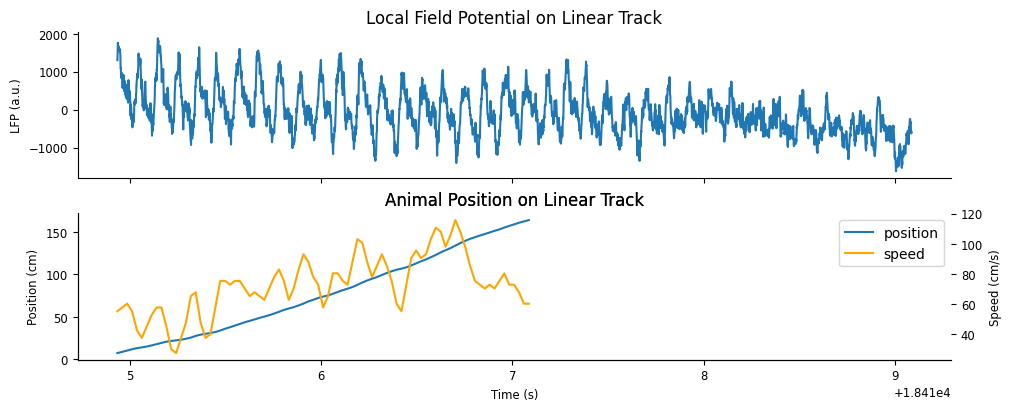

In [19]:
fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(10, 4), sharex=True)

# plot LFP
axs[0].plot(ex_lfp)
axs[0].set_title("Local Field Potential on Linear Track")
axs[0].set_ylabel("LFP (a.u.)")

# plot animal's position
l1, = axs[1].plot(ex_position)
axs[1].set_title("Animal Position on Linear Track")
axs[1].set_ylabel("Position (cm)") 
axs[1].set_xlabel("Time (s)");

# plot animal's speed
ax = axs[1].twinx()
l2, = ax.plot(ex_speed, c="orange")
ax.set_title("Animal Position on Linear Track")
ax.set_ylabel("Speed (cm/s)")
axs[1].legend([l1,l2], ["position","speed"])

In [20]:
fig.savefig("../../_static/_check_figs/pc-01.png")

<div class="render-user">
:::{admonition} Figure check
:class: dropdown
![](../../_static/_check_figs/pc-01.png)
:::
</div>

<div class="render-all"> 

As we would expect, there is a strong theta oscillation dominating the LFP while the animal runs down the track. This oscillation is weaker after the run is complete.

</div>

## Part 2: 1D neural tuning and model fitting
### Computing 1D tuning curves: place fields

<div class="render-all">

First, we will look at the place selectivity of each unit. We can find place firing preferences of each unit by using the function [`nap.compute_tuning_curves`](https://pynapple.org/generated/pynapple.process.tuning_curves.html#pynapple.process.tuning_curves.compute_tuning_curves).

We'll filter for units that fire at least 1 Hz and at most 10 Hz when the animal is running forward along the linear track. This will select for units that are active during our window of interest and eliminate putative interneurons (i.e. fast-firing inhibitory neurons that don't usually have place selectivity). Afterwards, we'll compute the tuning curves for these sub-selected units over position.

</div>

#### 2.1 Restrict `spikes` to `forward_ep` and select for units whose rate is at least 1 Hz and at most 10 Hz

<div class="render-user">
```{code-cell} ipython3
# save the filtered spikes in the following variable
good_spikes = 
```
</div>

In [21]:
good_spikes = spikes[(spikes.restrict(forward_ep).rate >= 1) & (spikes.restrict(forward_ep).rate <= 10)]

#### 2.2 Compute tuning curves with respect to `position` for units in `good_spikes`.

<div class="render-all">

- Use 50 position bins
- Name the feature `"position"` using the optional argument `feature_names`

</div>

<div class="render-user">
```{code-cell} ipython3
place_fields = 
```
</div>

In [22]:
place_fields = nap.compute_tuning_curves(good_spikes, position, 50, feature_names=["position"])

<div class="render-all">

This function returns tuning curves as an `xarray.DataArray`, with coordinates for unit (first dimension) and position (second dimension). An `xarray.DataArray` object provides convenient tools for plotting and other manipulations, and it scales well for tuning curves with more than 1 feature. 

</div>

:::{admonition} Tip
:class: tip render-all

The reason [`nap.compute_tuning_curves`](https://pynapple.org/generated/pynapple.process.tuning_curves.html#pynapple.process.tuning_curves.compute_tuning_curves) returns a `xarray.DataArray` and not a Pynapple object is because the array elements no longer correspond to *time*, which Pynapple objects require.
:::

<div class="render-all">

We can use the `xarray.DataArray` `plot` method to easily plot each unit, focusing on three example units.

</div>

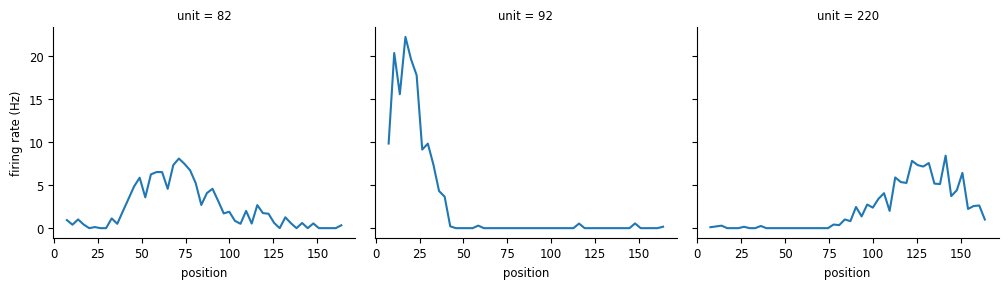

In [23]:
neurons = [82, 92, 220]
p = place_fields.sel(unit=neurons).plot(x="position", col="unit")
p.set_ylabels("firing rate (Hz)")

In [24]:
p.fig.savefig("../../_static/_check_figs/pc-02.png")

<div class="render-user">
:::{admonition} Figure check
:class: dropdown
![](../../_static/_check_figs/pc-02.png)
:::
</div>

<div class="render-all">
    
We can see clear spatial selectivity in these example units, where firing rate peaks at specific positions along the track.

Let's repeat this exercise, but instead compute tuning curves as a function of *speed* instead of position.

</div>

#### 2.3 Compute tuning curves with respect to `speed` for units in `good_spikes`.

<div class="render-all">

- Use 30 speed bins
- Name the feature `"speed"` using the optional argument `feature_names`

</div>

<div class="render-user">
```{code-cell} ipython3
speed_fields = 
```
</div>

In [25]:
speed_fields = nap.compute_tuning_curves(spikes, speed, bins=30, epochs=speed.time_support, feature_names=["speed"])

<div class="render-all">
    
Let's compare the position tuning with the speed tuning of select neurons.

</div>

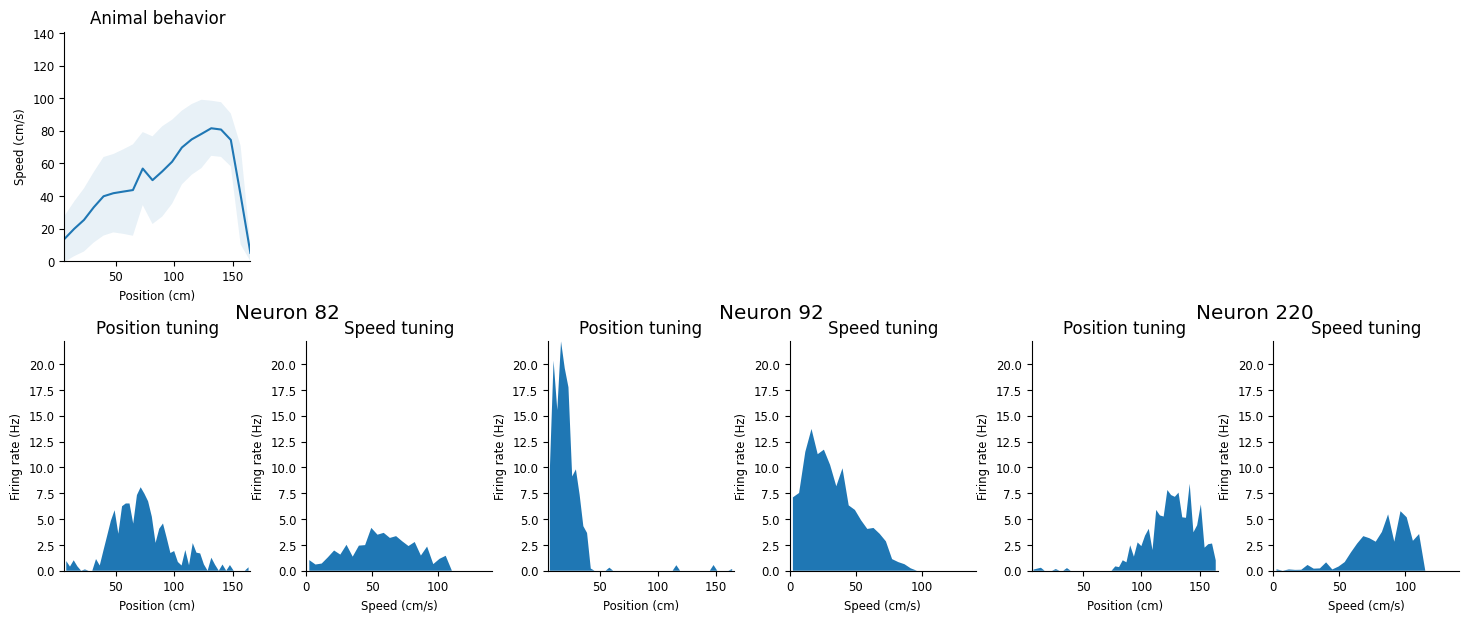

In [26]:
fig = workshop_utils.plot_position_speed(position, speed, place_fields.sel(unit=neurons), speed_fields.sel(unit=neurons), neurons);

In [27]:
fig.savefig("../../_static/_check_figs/pc-03.png")

<div class="render-user">
:::{admonition} Figure check
:class: dropdown
![](../../_static/_check_figs/pc-03.png)
:::
</div>


<div class="render-all">

These neurons all show both position and speed tuning, and we see that the animal's speed and position are highly correlated. How can we disentangle which variable is responsible for driving neural activity? This is where NeMoS comes in handy: GLMs can help us model responses to multiple, potentially correlated predictors. 

The goal of the remaining exercises in this section is to fit a PopulationGLM including both position and speed as predictors, and check if this model accurately captures the tuning curves of the neurons.

</div>

### Estimating tuning curves using a population GLM

<div class="render-all">
    
As we've seen before, we will use basis objects to represent the input values.  In previous tutorials, we've used the `Conv` basis objects to represent the time-dependent effects we were looking to capture. Here, we're trying to capture the non-linear relationship between our input variables and firing rate, so we want the `Eval` objects. In these circumstances, you should look at the tuning you're trying to capture and compare to the [basis kernels (visualized in NeMoS docs)](https://nemos.readthedocs.io/en/latest/background/basis/README.html#): you want your tuning to be capturable by a linear combination of them.

In this case, several of these would probably work; we will use [`BSplineEval`](https://nemos.readthedocs.io/en/latest/generated/basis/nemos.basis.BSplineEval.html#nemos.basis.BSplineEval) for both, though with different numbers of basis functions.

Additionally, since we have two different inputs, we'll need two separate basis objects.

</div>

:::{note}
:class: render-all

This afternoon, we'll show how to cross-validate across basis identity, which you can use to choose the basis.

:::

#### 2.4 Compute observations by counting spikes, using the pynapple method `count`, on our `TsGroup` of spike times, `good_spikes`.

<div class="render-all">

- For speed later on, only compute `count` on our example units by indexing `good_spikes` with `neurons`
- Use a `bin_size` of 10 ms (0.01s)
- Pass `forward_ep` as the optional argument `ep` to make sure we're only counting during forward runs.

</div>

<div class="render-user">
```{code-cell} ipython3
bin_size = 
counts = 
```
</div>

In [28]:
bin_size = 0.01
counts = good_spikes[neurons].count(bin_size, ep=forward_ep)

<div class="render-all">

By using this bin size for spike counts, `counts` will have a much higher sampling rate, and therefore have more data points, than our features, `position` and `speed`. We'll need to upsample our features to match the number of time points in `counts` in order to create a design matrix of the correct size to fit the model. We can achieve this by using the pynapple object method [`interpolate`](https://pynapple.org/generated/pynapple.Tsd.interpolate.html). This method will linearly interpolate new position and speed samples between existing samples at timestamps given by another pynapple object, in our case by `counts`.

</div>

#### 2.5 Upsample `position` and `speed` using the pynapple method [`interpolate`](https://pynapple.org/generated/pynapple.Tsd.interpolate.html) with the time stamps from `counts`.

<div class="render-all">

- Use a `bin_size` of 10 ms (0.01s)

</div>

<div class="render-user">
```{code-cell} ipython3
up_position = 
up_speed = 
```
</div>

In [29]:
up_position = position.interpolate(counts)
up_speed = speed.interpolate(counts)

<div class="render-all">
    
As we've seen before, we will use basis objects to represent the input values.  In previous tutorials, we've used the `Conv` basis objects to represent the time-dependent effects we were looking to capture. Here, we're trying to capture the non-linear relationship between our input variables and firing rate, so we want the `Eval` objects. In these circumstances, you should look at the tuning you're trying to capture and compare to the [basis kernels (visualized in NeMoS docs)](https://nemos.readthedocs.io/en/latest/background/basis/README.html#): you want your tuning to be capturable by a linear combination of them.

In this case, several of these would probably work; we will use [`BSplineEval`](https://nemos.readthedocs.io/en/latest/generated/basis/nemos.basis.BSplineEval.html#nemos.basis.BSplineEval) for both, though with different numbers of basis functions.

Additionally, since we have two different inputs, we'll need two separate basis objects.

</div>

:::{note}
:class: render-all

This afternoon, we'll show how to cross-validate across basis identity, which you can use to choose the basis.

:::

(basis-eval-place-cells-full)=
#### 2.6 Instantiate the basis by doing the following:

<div class="render-all">

- Create a separate basis object for each model input (speed and position).
- Use `BSplineEval` basis with, using 12 basis functions for position and 6 basis functions for speed.
- Provide a label for each basis ("position" and "speed").

We'll use a helper function to visualize the resulting basis functions.

</div>

<div class="render-user">
```{code-cell} ipython3
position_basis = 
speed_basis = 
workshop_utils.plot_pos_speed_bases(position_basis, speed_basis)
```
</div>

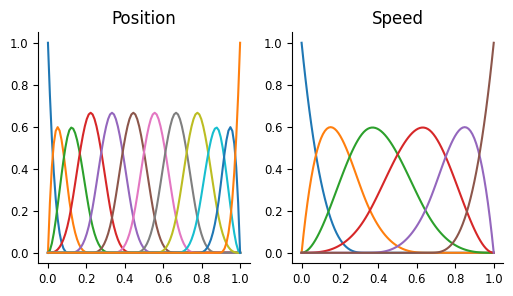

In [30]:
position_basis = nmo.basis.BSplineEval(n_basis_funcs=12, label="position")
speed_basis = nmo.basis.BSplineEval(n_basis_funcs=6, label="speed")
fig = workshop_utils.plot_pos_speed_bases(position_basis, speed_basis)

In [31]:
fig.savefig("../../_static/_check_figs/pc-04.png")

<div class="render-user">
:::{admonition} Figure check
:class: dropdown
![](../../_static/_check_figs/pc-04.png)
:::
</div>

<div class="render-all">
    
However, now we have an issue: in all our previous examples, we had a single basis object, which took a single input to produce a single array which we then passed to the `GLM` object as the design matrix. What do we do when we have multiple basis objects?

To do this, we can use [NeMoS basis composition](https://nemos.readthedocs.io/en/latest/background/basis/plot_02_ND_basis_function.html), where you can add the two bases together and obtain a new additive basis. We can similarly call `compute_features` on this additive basis, passing both position and speed, to obtain the same design matrix. For people familiar with NumPy, this is equivalent to calling `basis.compute_features()` for each basis separately and then [concatenate](https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html) the outputs.

</div>

#### 2.7 Create an additive basis by adding together `position_basis` and `speed_basis`.

<div class="render-user">
```{code-cell} ipython3
additive_basis = 
```
</div>

In [32]:
additive_basis = position_basis + speed_basis

#### 2.8 Create a design matrix by passing `up_position` and `up_speed` to the basis method `compute_features`

<div class="render-all">

- Make sure the features are passed in the same order that the basis objects were added together!

</div>

<div class="render-user">
```{code-cell} ipython3
X = 
```
</div>

In [33]:
X = additive_basis.compute_features(up_position, up_speed)
X

Time (s)                0          1           2            3    4  ...
---------------  --------  ---------  ----------  -----------  ---  -----
18193.603802655  0.907242  0.0912531  0.00149924  5.42445e-06    0  ...
18193.613802655  0.883494  0.114102   0.00239357  1.10303e-05    0  ...
18193.623802655  0.860164  0.136327   0.00348961  1.95736e-05    0  ...
18193.633802655  0.823097  0.171168   0.00569461  4.13443e-05    0  ...
18193.643802655  0.786239  0.205202   0.00848273  7.61954e-05    0  ...
18193.653802655  0.75855   0.230345   0.0109914   0.00011358     0  ...
18193.663802655  0.744462  0.24299    0.0124107   0.000137028    0  ...
...                                                                 ...
20123.332682821  0         0          0           0              0  ...
20123.342682821  0         0          0           0              0  ...
20123.352682821  0         0          0           0              0  ...
20123.362682821  0         0          0           0           

<div class="render-all">

Notice that, since we passed pynapple objects to the basis object, we got a pynapple object back, preserving the time stamps. Additionally, `X` has the same number of time points as our input position and speed, but 20 columns. The columns come from  `n_basis_funcs` from each basis (10 for position, 10 for speed).

As we've done before, we can now use the Poisson GLM from NeMoS to learn the combined model.

</div>

#### 2.9 Fit a GLM by doing the following:

<div class="render-all">

- Initialize `PopulationGLM`
- Use the "LBFGS" solver and pass `{"tol": 1e-12}` to `solver_kwargs`.
- Fit the data, passing the design matrix `X` and spike counts `counts` to the glm object.

</div>

<div class="render-user">
```{code-cell} ipython3
# define the model
glm =
# fit
glm.fit(
```
</div>

In [34]:
glm = nmo.glm.PopulationGLM(
    solver_kwargs={"tol": 1e-12},
    solver_name="LBFGS",
)
glm.fit(X, counts)

/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


,observation_model,PoissonObservations()
,inverse_link_function,<function exp...x7f4374c277e0>
,regularizer,UnRegularized()
,regularizer_strength,None
,solver_name,'LBFGS'
,solver_kwargs,{'tol': 1e-12}
,feature_mask,None


<div class="render-all">

Let's check first if our model can accurately predict the tuning curves we displayed above. We can use the [`predict`](https://nemos.readthedocs.io/en/latest/generated/glm/nemos.glm.GLM.predict.html#nemos.glm.GLM.predict) function of NeMoS and then compute new tuning curves using pynapple. 

</div>

#### 2.10 Use [`predict`](https://nemos.readthedocs.io/en/latest/generated/glm/nemos.glm.GLM.predict.html#nemos.glm.GLM.predict) to calculated the predicted firing rate of our model. Use the predicted rate to compute predicted tuning curves using [`nap.compute_tuning_curves`](https://pynapple.org/generated/pynapple.process.tuning_curves.html#pynapple.process.tuning_curves.compute_tuning_curves).

<div class="render-all">

- Remember to convert the predicted firing rate to spikes per second!
- Use 50 bins for position tuning curves and 30 bins for speed tuning curves.

</div>

<div class="render-user">
```{code-cell} ipython3
# predict the model's firing rate
predicted_rate =
# compute the position and speed tuning curves using the predicted firing rate.
glm_tuning_pos = 
glm_tuning_speed = 
```
</div>

In [35]:
# predict the model's firing rate
predicted_rate = glm.predict(X) / bin_size

# same shape as the counts we were trying to predict
print(predicted_rate.shape, counts.shape)

# compute the position and speed tuning curves using the predicted firing rate.
glm_tuning_pos = nap.compute_tuning_curves(predicted_rate, position, bins=50, epochs=position.time_support, feature_names=["position"])
glm_tuning_speed = nap.compute_tuning_curves(predicted_rate, speed, bins=30, epochs=speed.time_support, feature_names=["speed"])

(19237, 3) (19237, 3)


<div class="render-all">

We can plot the results to compare the model and data tuning curves.

</div>

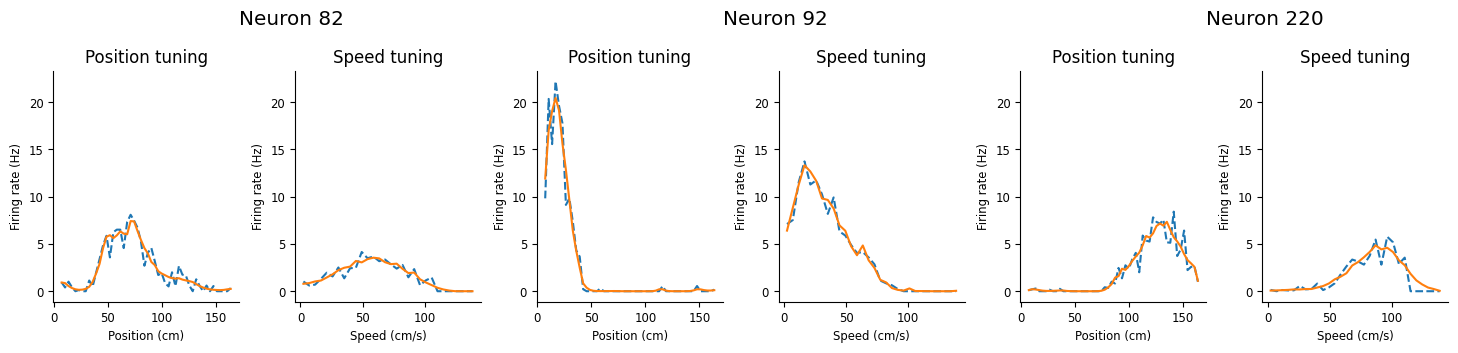

In [36]:
fig = workshop_utils.plot_position_speed_tuning(place_fields.sel(unit=neurons), speed_fields.sel(unit=neurons), glm_tuning_pos, glm_tuning_speed);

In [37]:
fig.savefig("../../_static/_check_figs/pc-05.png", bbox_inches="tight")

<div class="render-user">
:::{admonition} Figure check
:class: dropdown
![](../../_static/_check_figs/pc-05.png)
:::
</div>

<div class="render-all">

We can see that this model does a good job capturing both the position and the speed. 

</div>

## Part 3: Signal processing
### Getting the Wavelet Decomposition

<div class="render-all">

Next we'll use pynapple's signal processing module to analyze LFP and visualize phase precessing within hippocampal place cells. We'll start by performing a wavelet decomposition on the LFP trace during example run 9 that saved in **1.3** as the Tsd `ex_lfp`. We can do this in pynapple using the function [`nap.compute_wavelet_transform`](https://pynapple.org/generated/pynapple.process.wavelets.html#pynapple.process.wavelets.compute_wavelet_transform).

A [continuous wavelet transform](https://en.wikipedia.org/wiki/Continuous_wavelet_transform) decomposes a signal into a set of [wavelets](https://en.wikipedia.org/wiki/Wavelet), in this case [Morlet wavelets](https://en.wikipedia.org/wiki/Morlet_wavelet), that span both frequency and time. You can think of the wavelet transform as a cross-correlation between the signal and each wavelet, giving the similarity between the signal and various frequency components at each time point of the signal. Similar to a Fourier transform, this gives us an estimate of what frequencies are dominating a signal. Unlike the Fourier tranform, however, the wavelet transform gives us this estimate as a function of time.

We must define the frequency set that we'd like to use for our decomposition. We can do this with the numpy function [`np.geomspace`](https://numpy.org/doc/stable/reference/generated/numpy.geomspace.html), which returns numbers evenly spaced on a log scale. We pass the lower frequency, the upper frequency, and number of samples as positional arguments.

</div>

#### 3.1 Define 100 log-spaced samples between 5 and 200 Hz using [`np.geomspace`](https://numpy.org/doc/stable/reference/generated/numpy.geomspace.html)

<div class="render-user">
```{code-cell} ipython3
# 100 log-spaced samples between 5Hz and 200Hz
freqs = 
```
</div>

In [38]:
# 100 log-spaced samples between 5Hz and 200Hz
freqs = np.geomspace(5, 200, 100)

<div class="render-all">

We can now compute the wavelet transform on our LFP data during the example run using [`nap.compute_wavelet_transform`](https://pynapple.org/generated/pynapple.process.wavelets.html#pynapple.process.wavelets.compute_wavelet_transform) by passing both `ex_lfp` and `freqs`. We'll also pass the optional argument `fs`, which is known to be 1250Hz from the study methods.

</div>

#### 3.2 Compute the wavelet transform of `ex_lfp` using `freqs` defined above.

<div class="render-all">

- Supply the known sampling rate, 1250 Hz, as the optional argument `fs` 

</div>


<div class="render-user">  
```{code-cell} ipython3
sample_rate = 1250
ex_cwt =
```
</div>

In [39]:
sample_rate = 1250
ex_cwt = nap.compute_wavelet_transform(ex_lfp, freqs, fs=sample_rate)

:::{admonition} Note
:class: tip render-all
If `fs` is not provided, it can be inferred from the time series [`rate`](https://pynapple.org/generated/pynapple.Tsd.html#id0) attribute, e.g. `ex_lfp.rate`. However, while inferred rate is close to the true sampling rate, it can introduce a small floating-point error. Therefore, it is better to supply the true sampling rate when it is known.
:::

<div class="render-all">
    
We can visualize the results by plotting a heat map of the calculated wavelet scalogram.

</div>

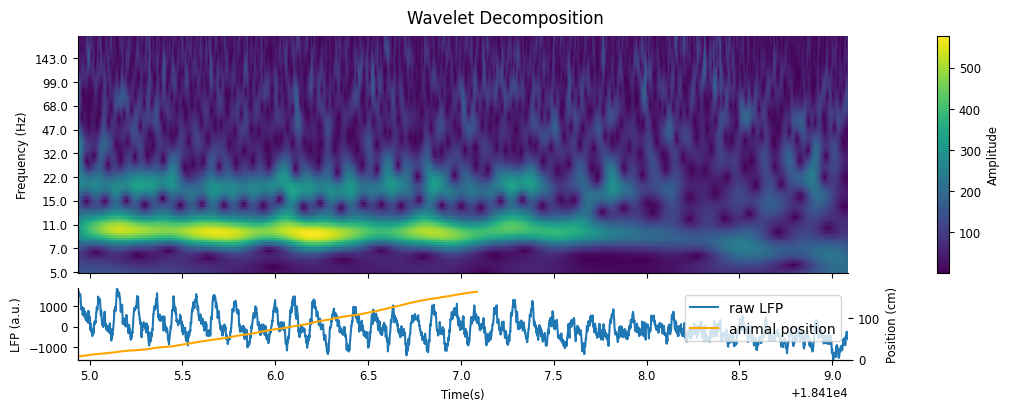

In [40]:
fig, axs = plt.subplots(2, 1, figsize=(10,4), constrained_layout=True, height_ratios=[1.0, 0.3], sharex=True)
fig.suptitle("Wavelet Decomposition")

amp = np.abs(ex_cwt.values)
cax = axs[0].pcolormesh(ex_cwt.t, freqs, amp.T)
axs[0].set(ylabel="Frequency (Hz)", yscale='log', yticks=freqs[::10], yticklabels=np.rint(freqs[::10]));
axs[0].minorticks_off()
fig.colorbar(cax,label="Amplitude")

p1 = axs[1].plot(ex_lfp)
axs[1].set(ylabel="LFP (a.u.)", xlabel="Time(s)")
axs[1].margins(0)
ax = axs[1].twinx()
p2 = ax.plot(ex_position, color="orange")
ax.set_ylabel("Position (cm)")
ax.legend([p1[0], p2[0]],["raw LFP","animal position"])

In [41]:
fig.savefig("../../_static/_check_figs/pc-06.png")

<div class="render-user">
:::{admonition} Figure check
:class: dropdown
![](../../_static/_check_figs/pc-06.png)
:::
</div>

<div class="render-all">
    
You should see a strong presence of theta in the 6-12Hz frequency band while the animal runs down the track, which dampens during rest.

</div>

### Computing theta phase

<div class="render-all">

To capture phase precession, we will need to compute the phase of the theta oscillation present in the LFP. Similar to our analysis of position, we only want to compute theta phase during forward runs down the track, where the theta power will be strongest.

</div>

#### 3.3 Restrict `lfp` to `forward_ep`.

<div class="render-all">

- Confirm that `position` is already be restricted to this epoch from **1.1**. If not, also restrict `position` to `forward_ep`

</div>

<div class="render-user">  
```{code-cell} ipython3
lfp = 
position = 
```
</div>

In [42]:
lfp = lfp.restrict(forward_ep)
position = position.restrict(forward_ep)

<div class="render-all">

We can extract the theta oscillation by applying a bandpass filter on the raw LFP. To do this, we use the pynapple function [`nap.apply_bandpass_filter`](https://pynapple.org/generated/pynapple.process.filtering.html#pynapple.process.filtering.apply_bandpass_filter). Conveniently, this function will recognize and handle splits in the epoched data (i.e. applying the filtering separately to discontinuous epochs), so we don't have to worry about passing signals that have been split in time.

</div>

#### 3.4 Using [`nap.apply_bandpass_filter`](https://pynapple.org/generated/pynapple.process.filtering.html#pynapple.process.filtering.apply_bandpass_filter), filter `lfp` for theta within a 6-12 Hz range.

<div class="render-all">

- Same as before, pass the sampling rate of 1250 Hz (`sample_rate`)

</div>


<div class="render-user">   
```{code-cell} ipython3
theta_band = 
```
</div>

In [43]:
theta_band = nap.apply_bandpass_filter(lfp, (6.0, 12.0), fs=sample_rate)

<div class="render-all">

We can visualize the output by plotting the filtered signal with the original signal.

</div>

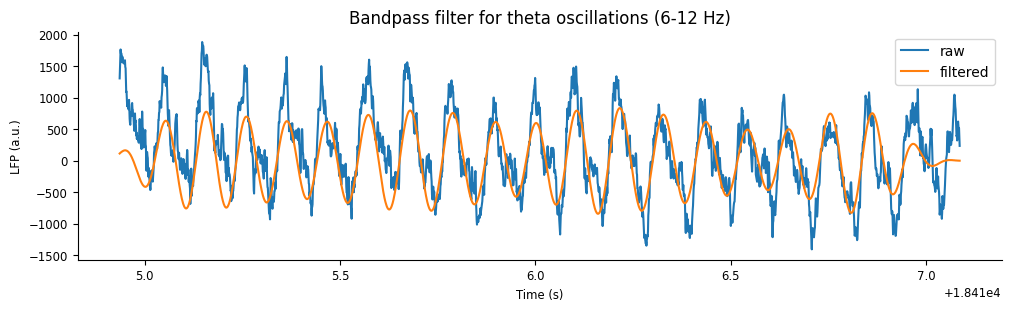

In [44]:
ex_run_ep = nap.IntervalSet(start=forward_ep[9].start, end=forward_ep[9].end)
fig = plt.figure(constrained_layout=True, figsize=(10, 3))
plt.plot(lfp.restrict(ex_run_ep), label="raw")
plt.plot(theta_band.restrict(ex_run_ep), label="filtered")
plt.xlabel("Time (s)")
plt.ylabel("LFP (a.u.)")
plt.title("Bandpass filter for theta oscillations (6-12 Hz)")
plt.legend();

In [45]:
fig.savefig("../../_static/_check_figs/pc-07.png")

<div class="render-user">
:::{admonition} Figure check
:class: dropdown
![](../../_static/_check_figs/pc-07.png)
:::
</div>

<div class="render-all">

Finally, we need to extract the phase of theta from the filtered signal. We can do this by taking the angle of the [Hilbert transform](https://en.wikipedia.org/wiki/Hilbert_transform).

</div>

#### 3.5 Use [`sp.signal.hilbert`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.hilbert.html) to perform the Hilbert transform of `theta_band`, using [`np.angle`](https://numpy.org/doc/2.3/reference/generated/numpy.angle.html) to extract the angle. Convert the output angle to a [0, 2pi] range, and store the result in a `Tsd` object.

<div class="render-all">

- TIP: don't forget to pass the time support!
- The code for wrapping the phase from [0, 2pi] is provided, by taking the [modulo](https://en.wikipedia.org/wiki/Modulo) of all angles with 2pi. (When all values are between -pi, and pi, this is equivalent to adding 2pi to all negative angles.)
  
</div>

<div class="render-user"> 
```{code-cell} ipython3
# compute the phase
phase = 
phase %= 2 * np.pi # wrap to [0,2pi]
# store as a Tsd
theta_phase = 
```
</div>

In [46]:
phase = np.angle(sp.signal.hilbert(theta_band)) # compute phase with hilbert transform
phase %= 2 * np.pi # wrap to [0,2pi]
theta_phase = nap.Tsd(t=theta_band.t, d=phase, time_support=theta_band.time_support)
theta_phase

Time (s)
----------  -------
18193.5992  5.38742
18193.6     5.74591
18193.6008  5.76537
18193.6016  5.9562
18193.6024  5.9812
18193.6032  6.12091
18193.604   6.14975
...
20123.392   4.72464
20123.3928  4.71239
20123.3936  4.71239
20123.3944  4.71239
20123.3952  4.71239
20123.396   4.71239
20123.3968  4.71239
dtype: float64, shape: (240384,)

<div class="render-all">

Let's plot the phase on top of the filtered LFP signal, zooming in on a few cycles.

</div>

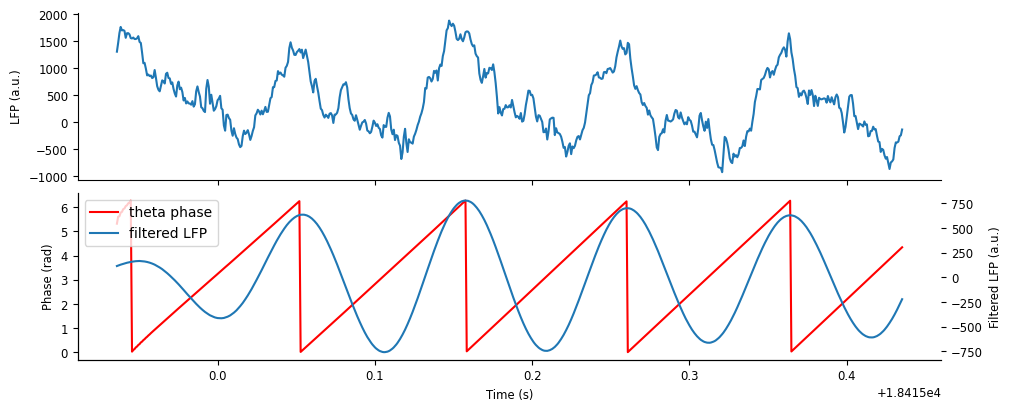

In [47]:
ex_run_shorter = nap.IntervalSet(ex_run_ep.start[0], ex_run_ep.start[0]+0.5)
fig,axs = plt.subplots(2,1,figsize=(10,4), constrained_layout=True, sharex=True)#, height_ratios=[2,1])
ax = axs[0]
ax.plot(lfp.restrict(ex_run_shorter))
ax.set_ylabel("LFP (a.u.)")
ax = axs[1]
p1 = ax.plot(theta_phase.restrict(ex_run_shorter), color='r')
ax.set_ylabel("Phase (rad)")
ax.set_xlabel("Time (s)")
ax = ax.twinx()
p2 = ax.plot(theta_band.restrict(ex_run_shorter))
ax.set_ylabel("Filtered LFP (a.u.)")
ax.legend([p1[0],p2[0]],["theta phase","filtered LFP"])

In [48]:
fig.savefig("../../_static/_check_figs/pc-08.png")

<div class="render-user">
:::{admonition} Figure check
:class: dropdown
![](../../_static/_check_figs/pc-08.png)
:::
</div>

### Visualizing phase precession within a single unit

<div class="render-all">
    
As an initial visualization of phase precession, we'll look at a single traversal of the linear track. First, let's look at how the timing of an example unit's spikes lines up with the LFP and theta. To plot the spike times on the same axis as the LFP, we'll use the pynapple object's method [`value_from`](https://pynapple.org/generated/pynapple.TsGroup.value_from.html) to align the spike times with the theta amplitude. For our spiking data, this will find the amplitude closest in time to each spike. Let's start by applying [`value_from`](https://pynapple.org/generated/pynapple.TsGroup.value_from.html) on unit 177, who's place field is cenetered on the linear track, using `theta_band` to align the amplityde of the filtered LFP.

#### 3.6 Use the pynapple object method [`value_from`](https://pynapple.org/generated/pynapple.TsGroup.value_from.html) to find the value of `theta_band` corresponding to each spike time from unit 177.

</div>

<div class="render-user">  
```{code-cell} ipython3
unit = 177
spike_theta = 
```
</div>

In [49]:
unit = 177
spike_theta = spikes[unit].value_from(theta_band)

<div class="render-all">

Let's plot `spike_theta` on top of the LFP and filtered theta, as well as visualize the animal's position along the track.

</div>

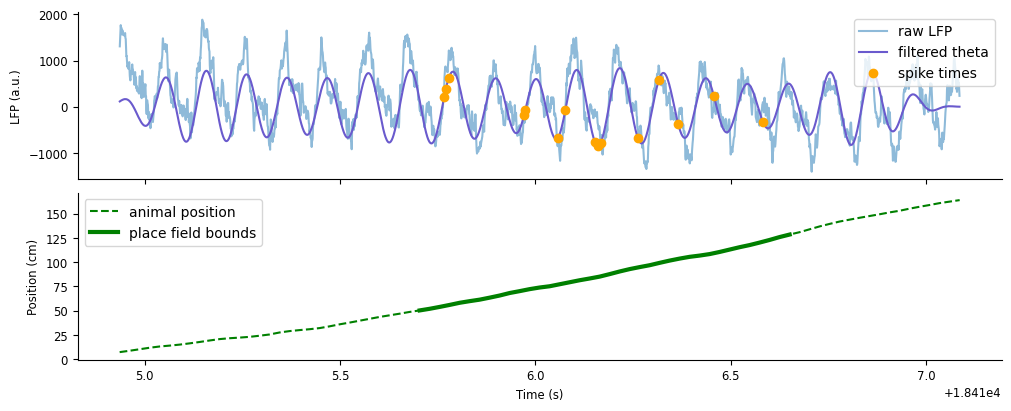

In [50]:
fig,axs = plt.subplots(2, 1, figsize=(10,4), constrained_layout=True, sharex=True)
axs[0].plot(lfp.restrict(ex_run_ep), alpha=0.5, label="raw LFP")
axs[0].plot(theta_band.restrict(ex_run_ep), color="slateblue", label="filtered theta")
axs[0].plot(spike_theta.restrict(ex_run_ep), 'o', color="orange", label="spike times")
axs[0].set(ylabel="LFP (a.u.)")
axs[0].legend()

axs[1].plot(ex_position, '--', color="green", label="animal position")
axs[1].plot(ex_position[(ex_position > 50).values & (ex_position < 130).values], color="green", lw=3, label="place field bounds")
axs[1].set(ylabel="Position (cm)", xlabel="Time (s)")
axs[1].legend()

In [51]:
fig.savefig("../../_static/_check_figs/pc-09.png")

<div class="render-user">
:::{admonition} Figure check
:class: dropdown
![](../../_static/_check_figs/pc-09.png)
:::
</div>

<div class="render-all">
    
As the animal runs through unit 177's place field (thick green), the unit spikes (orange dots) at specific points along the theta cycle dependent on position: starting at the rising edge, moving towards the trough, and ending at the falling edge.

We can exemplify this pattern by plotting the spike times aligned to the phase of theta. We'll want the corresponding phase of theta at which the unit fires as the animal is running down the track, which we can again compute using the method [`value_from`](https://pynapple.org/generated/pynapple.TsGroup.value_from.html). 

</div>

#### 3.7 Compute the value of `theta_phase` corresponding to each spike time from unit 177.

<div class="render-user">  
```{code-cell} ipython3
spike_phase = 
```
</div>

In [52]:
spike_phase = spikes[unit].value_from(theta_phase)

<div class="render-all">

To visualize the results, we'll recreate the plot above, but instead with the theta phase.

</div>

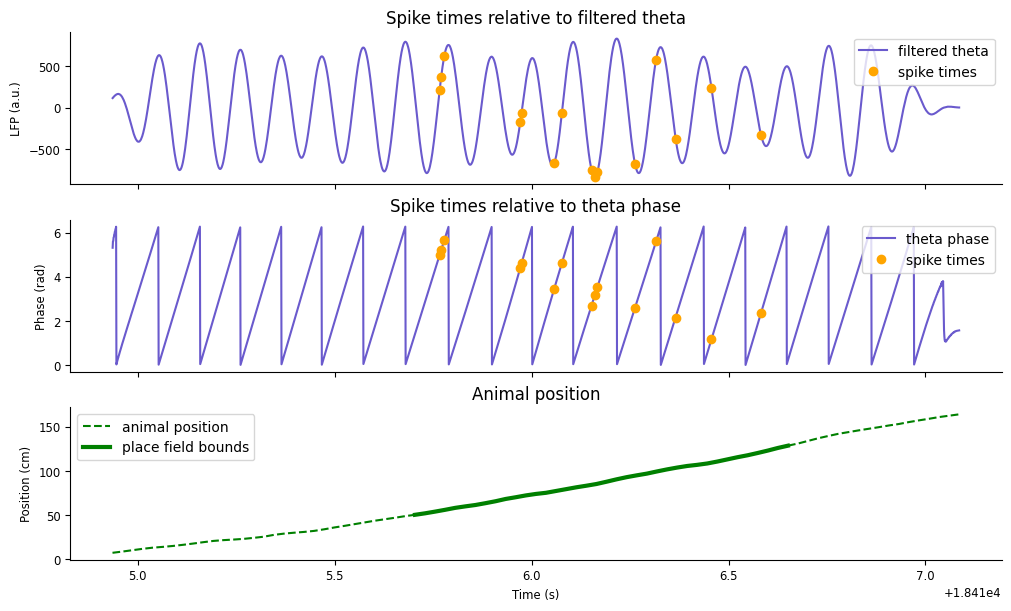

In [53]:
fig,axs = plt.subplots(3, 1, figsize=(10,6), constrained_layout=True, sharex=True)
axs[0].plot(theta_band.restrict(ex_run_ep), color="slateblue", label="filtered theta")
axs[0].plot(spike_theta.restrict(ex_run_ep), 'o', color="orange", label="spike times")
axs[0].set(ylabel="LFP (a.u.)", title="Spike times relative to filtered theta")
axs[0].legend()

axs[1].plot(theta_phase.restrict(ex_run_ep), color="slateblue", label="theta phase")
axs[1].plot(spike_phase.restrict(ex_run_ep), 'o', color="orange", label="spike times")
axs[1].set(ylabel="Phase (rad)", title="Spike times relative to theta phase")
axs[1].legend()

axs[2].plot(ex_position, '--', color="green", label="animal position")
axs[2].plot(ex_position[(ex_position > 50).values & (ex_position < 130).values], color="green", lw=3, label="place field bounds")
axs[2].set(ylabel="Position (cm)", xlabel="Time (s)", title="Animal position")
axs[2].legend()

In [54]:
fig.savefig("../../_static/_check_figs/pc-10.png")

<div class="render-user">
:::{admonition} Figure check
:class: dropdown
![](../../_static/_check_figs/pc-10.png)
:::
</div>

<div class="render-all">
    
We now see a negative trend in the spike phase as the animal moves through unit 177's place field. This phemomena is known as phase precession: the phase at which a unit spikes *precesses* (gets earlier) as the animal runs through that unit's place field. Explicitly, that unit will spike at *late* phases of theta (higher radians) in *earlier* positions in the field, and fire at *early* phases of theta (lower radians) in *late* positions in the field.

We can observe this phenomena on average across the session by relating the spike phase to the spike position. 

</div>

#### 3.8 Compute the position corresponding to each spike for example unit 177.

<div class="render-user">
```{code-cell} ipython3
spike_position = 
```
</div>

In [55]:
spike_position = spikes[unit].value_from(position)

<div class="render-all">

Now we can plot the spike phase against the spike position in a scatter plot.

</div>

Text(0.5, 0, 'Position (cm)')

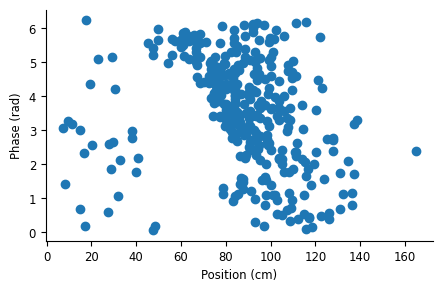

In [56]:
fig, axs = plt.subplots(figsize=(5,3))
axs.plot(spike_position, spike_phase, 'o')
axs.set_ylabel("Phase (rad)")
axs.set_xlabel("Position (cm)")

In [57]:
fig.savefig("../../_static/_check_figs/pc-11.png")

<div class="render-user">
:::{admonition} Figure check
:class: dropdown
![](../../_static/_check_figs/pc-11.png)
:::
</div>


<div class="render-all">
    
Similar to what we saw in a single run, there is a negative relationship between theta phase and field position, characteristic of phase precession.

</div>

## Part 4: 2D neural tuning and model fitting
### Computing 2D tuning curves: position vs. phase

<div class="render-all">

The scatter plot above can be similarly be represented as a 2D tuning curve over position and phase. We can compute this using the same function, [`nap.compute_tuning_curves`](https://pynapple.org/generated/pynapple.process.tuning_curves.html#pynapple.process.tuning_curves.compute_tuning_curves), but now passing second input, `features`, as a 2-column `TsdFrame` containing the two target features.

To do this, we'll need to combine `position` and `theta_phase` into a `TsdFrame`. For this to work, both variables must have the same length. Similar to what we did in Part 2, we can achieve this by upsampling `position` to the length of `theta_phase` using the pynapple object method [`interpolate`](https://pynapple.org/generated/pynapple.Tsd.interpolate.html). Once they're the same length, they can be combined into a single `TsdFrame` and used to compute 2D tuning curves.

</div>

#### 4.1 Interpolate `position` to the time points of `theta_phase`.

<div class="render-user"> 
```{code-cell} ipython3
upsampled_pos = 
```
</div>

In [58]:
upsampled_pos = position.interpolate(theta_phase)

#### 4.2 Stack `upsampled_pos` and `theta_phase` together into a single [`TsdFrame`](https://pynapple.org/generated/pynapple.TsdFrame.html)

<div class="render-all">

- For stacking arrays, you can use a numpy function like `np.stack`.
    - Tip: you may need to transpose to make sure time is in the first dimension of the stacked array
- Make sure to name your `TsdFrame` columns `"position"` and `"phase"`
  
</div>

<div class="render-user">  
```{code-cell} ipython3
# store the resulting TsdFrame into the following variable
features = 
```
</div>

In [59]:
feats = np.stack((upsampled_pos.values, theta_phase.values))
features = nap.TsdFrame(
    t=theta_phase.t,
    d=np.transpose(feats),
    time_support=upsampled_pos.time_support,
    columns=["position", "phase"],
)
features

Time (s)      position    phase
----------  ----------  -------
18193.5992     6.31836  5.38742
18193.6        6.33044  5.74591
18193.6008     6.34251  5.76537
18193.6016     6.35459  5.9562
18193.6024     6.36667  5.9812
18193.6032     6.37875  6.12091
18193.604      6.39082  6.14975
...
20123.392    165.232    4.72464
20123.3928   165.24     4.71239
20123.3936   165.248    4.71239
20123.3944   165.256    4.71239
20123.3952   165.264    4.71239
20123.396    165.272    4.71239
20123.3968   165.28     4.71239
dtype: float64, shape: (240384, 2)

#### 4.3 Apply [`nap.compute_tuning_curves`](https://pynapple.org/generated/pynapple.process.tuning_curves.html#pynapple.process.tuning_curves.compute_tuning_curves) with `features` on our subselected group of units, `good_spikes`

<div class="render-all">

- Use 50 bins for position and 30 bins for theta phase

</div>

<div class="render-user">
```{code-cell} ipython3
tuning_curves =
```
</div>

In [60]:
tuning_curves = nap.compute_tuning_curves(good_spikes, features, bins=[50,30])

<div class="render-all">

We can plot 2D tuning curves for each unit and phase precession in some example units.

</div>

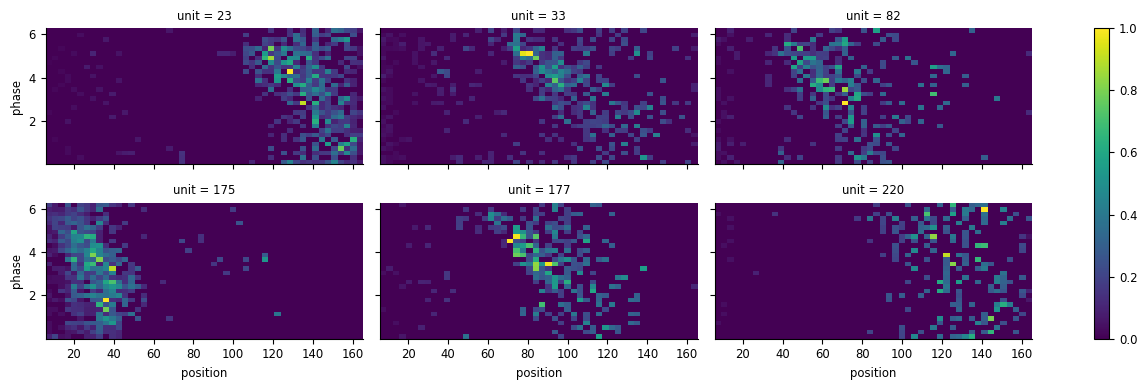

In [61]:
neurons = [23, 33, 82, 175, 177, 220]
tc_norm = tuning_curves / tuning_curves.max(axis=(1,2))
p = tc_norm.sel(unit=neurons).plot(x="position", y="phase", col="unit", col_wrap=3, size=2, aspect=2)

In [62]:
p.fig.savefig("../../_static/_check_figs/pc-12.png")

<div class="render-user">
:::{admonition} Figure check
:class: dropdown
![](../../_static/_check_figs/pc-12.png)
:::
</div>

<div class="render-all">

You should be able to notice a negative relationship between position and phase, characteristic of phase precession.

</div>

### Estimating 2D tuning curves using 2D basis functions

<div class="render-all">
    
How can we model 2D tuning curves in a GLM? Similar to Part 2, we can define a 2D basis by using [NeMoS basis composition](https://nemos.readthedocs.io/en/latest/background/basis/plot_02_ND_basis_function.html), but instead *multiplying* two basis objects. In fact, we can use both addition and multiplication together to create arbitrarily complex, multidimensional basis objects.

First, we'll create a basis object for theta phase, specifically using [`CyclicBSplineEval`](https://nemos.readthedocs.io/en/latest/generated/basis/nemos.basis.CyclicBSplineEval.html#nemos.basis.BSplineEval). We use this instead of `BSplineBasis` because the phase angle is a circular variable.

</div>

#### 4.4 Instantiate a [`CyclicBSplineEval`](https://nemos.readthedocs.io/en/latest/generated/basis/nemos.basis.CyclicBSplineEval.html#nemos.basis.BSplineEval) basis object for phase, using 10 basis functions.

<div class="render-all">

- Provide the label `"phase"` for the basis.
- If necessary, reinstantiate the basis objects for position, `position_basis`, and speed, `speed_basis`, as you did in **2.6**.

</div>

<div class="render-user">
```{code-cell} ipython3
phase_basis =
```
</div>

In [63]:
phase_basis = nmo.basis.CyclicBSplineEval(n_basis_funcs=10, label="phase")

#### 4.5 Create the full basis by multiplying `position_basis` and `phase_basis` and adding `speed_basis`.

<div class="render-user">
```{code-cell} ipython3
full_basis =
```
</div>

In [64]:
full_basis = position_basis * phase_basis + speed_basis
full_basis

,label,'((position * phase) + speed)'
,position__bounds,None
,position__label,'position'
,position__n_basis_funcs,12
,position__order,4
,position,"'position': B...s=12, order=4)"
,phase__bounds,None
,phase__label,'phase'
,phase__n_basis_funcs,10
,phase__order,4
,phase,"'phase': Cycl...s=10, order=4)"


<div class="render-all">

Before we can call `compute_features`, we need to make sure `theta_phase` has the same number of time points as `counts`. Since `theta_phase` has *more* time points than counts, we'll need to *downsample* the number of time points. We can do this using the pynapple object method [`bin_average`](https://pynapple.org/generated/pynapple.Tsd.bin_average.html). This function will average values within a specified bin size. We can achieve the same sampling rate by using the same bin size as we used for our spike counts.

</div>

#### 4.6 Downsample `theta_phase` using `bin_average` and a bin size of 0.01 s.

<div class="render-all">

- If necessary, redefine `up_position` and `up_speed` the same as **2.5**.

</div>

<div class="render-user">
```{code-cell} ipython3
bin_theta =
```
</div>

In [65]:
bin_theta = theta_phase.bin_average(0.01)

#### 4.7 Create a design matrix by calling `compute_features` on `full_basis` using `up_position`, `bin_theta`, and `up_speed`

<div class="render-user">
```{code-cell} ipython3
X =
```
</div>

In [66]:
X = full_basis.compute_features(up_position, bin_theta, up_speed)

#### 4.8 Fit a GLM by doing the following:

<div class="render-all">

- Initialize `PopulationGLM`
- Use the "LBFGS" solver and pass `{"tol": 1e-12}` to `solver_kwargs`.
- Fit the data, passing the design matrix `X` and spike counts `counts` to the glm object.
    - `counts` should have been computed before in **2.4**.

</div>


<div class="render-user">
```{code-cell} ipython3
glm =
```
</div>

In [67]:
glm = nmo.glm.PopulationGLM(
    solver_kwargs=dict(tol=10**-12),
    solver_name="LBFGS"
)

glm.fit(X, counts)

/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


,observation_model,PoissonObservations()
,inverse_link_function,<function exp...x7f4374c277e0>
,regularizer,UnRegularized()
,regularizer_strength,None
,solver_name,'LBFGS'
,solver_kwargs,{'tol': 1e-12}
,feature_mask,None


#### 4.9 Use [`predict`](https://nemos.readthedocs.io/en/latest/generated/glm/nemos.glm.GLM.predict.html#nemos.glm.GLM.predict) to calculated the predicted firing rate of our model. Use the predicted rate to compute predicted tuning curves using [`nap.compute_tuning_curves`](https://pynapple.org/generated/pynapple.process.tuning_curves.html#pynapple.process.tuning_curves.compute_tuning_curves).

<div class="render-all">

- Remember to convert the predicted firing rate to spikes per second!
- Compute 1D tuning curves for position and speeds in the same way as **2.10**.
- Compute 2D tuning curves for position x phase using `predicted_rate` and the TsdFrame `features`, using 50 bins for position and 30 bins for phase.

</div>

<div class="render-user">
```{code-cell} ipython3
# predict the model's firing rate
predicted_rate =
# compute the 1D tuning curves for position and speed
glm_pf = 
glm_speed = 
# compute 2D tuning curves for position x phase
glm_pos_theta =   
```
</div>

In [68]:
predicted_rate = glm.predict(X) / bin_size

glm_pf = nap.compute_tuning_curves(predicted_rate, position, 50, feature_names=["position"])
glm_speed = nap.compute_tuning_curves(predicted_rate, speed, 30, feature_names=["speed"])
glm_pos_theta = nap.compute_tuning_curves(
    predicted_rate, features, [50, 30], epochs=forward_ep
)

<div class="render-all">

We'll use a helper function from NeMoS to compare the predicted tuning curves to those computed from the data

</div>

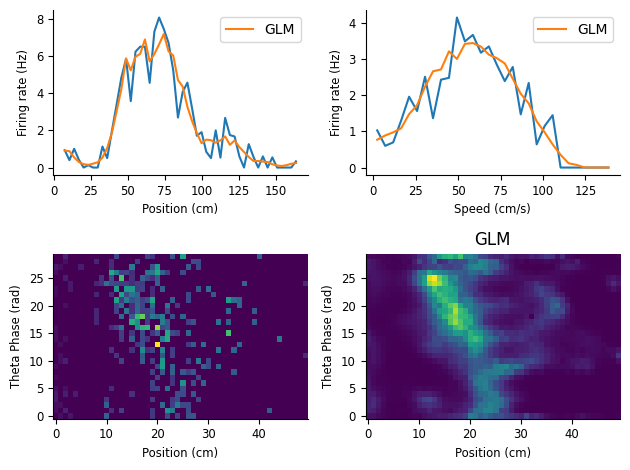

In [69]:
from nemos import _documentation_utils as doc_plots
neuron = 82
idx = np.where(glm_pf.unit == neuron)[0][0]
fig = doc_plots.plot_position_phase_speed_tuning(
    place_fields.sel(unit=neuron),
    glm_pf[idx],
    speed_fields.sel(unit=neuron),
    glm_speed[idx],
    tuning_curves.sel(unit=neuron),
    glm_pos_theta[idx],
    )

In [70]:
fig.savefig("../../_static/_check_figs/pc-13.png")

<div class="render-user">
:::{admonition} Figure check
:class: dropdown
![](../../_static/_check_figs/pc-13.png)
:::
</div>


### Bonus Exercise

<div class="render-all">

As an bonus, more open-ended exercise, we can investigate all the scientific decisions that we swept under the rug: should we regularize the model? What basis should we use? Do we need all inputs? If you're feeling ambitious, here are some suggestions to answer these questions:

- Try to fit and compare the results we just obtained with different models: 
  - A model with position as the only predictor.
  - A model with speed as the only predictor.
  - A model with phase as the only predictor
- Introduce L1 (Lasso) regularization and fit models with increasingly large penalty strengths ($\lambda$). Plot the regularization path showing how each coefficient changes with $\lambda$. Identify which coefficients remain non-zero longest as $\lambda$ increases - these correspond to the most informative predictors.

</div>

In [71]:
# bonus exercise

## Part 5: Neural decoding
### Decoding position from spiking activity

<div class="render-all">

Finally we'll do a popular analysis in the rat hippocampus sphere: Bayesian decoding. This analysis is an elegent application of Bayes' rule in predicting the animal's location (or other behavioral variables) given neural activity at some point in time. Refer to the dropdown box below for a more in-depth explanation.

:::{admonition} Background: Bayesian decoding
:class: dropdown
Recall Bayes' rule, written here in terms of our relevant variables:

$$P(position|spikes) = \frac{P(position)P(spikes|position)}{P(spikes)}$$

Our goal is to compute the unknown posterior $P(position|spikes)$ given known prior $P(position)$ and known likelihood $P(spikes|position)$. 

$P(position)$, also known as the *occupancy*, is the probability that the animal is occupying some position. This can be computed exactly by the proportion of the total time spent at each position, but in many cases it is sufficient to estimate the occupancy as a uniform distribution, i.e. it is equally likely for the animal to occupy any location.

The next term, $P(spikes|position)$, which is the probability of seeing some sequence of spikes across all neurons at some position. Computing this relys on the following assumptions:
1. Neurons fire according to a Poisson process (i.e. their spiking activity follows a Poisson distribution)
2. Neurons fire independently from one another.

While neither of these assumptions are strictly true, they are generally reasonable for pyramidal cells in hippocampus and allow us to simplify our computation of $P(spikes|position)$

The first assumption gives us an equation for $P(spikes|position)$ for a single neuron, which we'll call $P(spikes_i|position)$ to differentiate it from $P(spikes|position) = P(spikes_1,spikes_2,...,spikes_N|position)$, or the total probability across all $N$ neurons. The equation we get is that of the Poisson distribution:

$$
P(spikes_i|position) = \frac{(\tau f_i(position))^n e^{-\tau f_i(position)}}{n!}
$$

where $f_i(position)$ is the firing rate of the neuron at position $(position)$ (i.e. the tuning curve), $\tau$ is the width of the time window over which we're computing the probability, and $n$ is the total number of times the neuron spiked in the time window of interest.

The second assumptions allows us to simply combine the probabilities of individual neurons. Recall the product rule for independent events: $P(A,B) = P(A)P(B)$ if $A$ and $B$ are independent. Treating neurons as independent, then, gives us the following:

$$
P(spikes|position) = \prod_i P(spikes_i|position)
$$

The final term, $P(spikes)$, is inferred indirectly using the law of total probability:

$$P(spikes) = \sum_{position}P(position,spikes) = \sum_{position}P(position)P(spikes|position)$$

Another way of putting it is $P(spikes)$ is the normalization factor such that $\sum_{position} P(position|spikes) = 1$, which is achived by dividing the numerator by its sum.

If this method looks daunting, we have some good news: pynapple has it implemented already in the function `nap.decode_bayes`. All we'll need are the spikes, the tuning curves, and the width of the time window $\tau$.
:::

(phase-precess-cv-full)=
:::{admonition} Aside: Cross-validation
:class: tip 
    
Generally this method is cross-validated, which means you train the model on one set of data and test the model on a different, held-out data set. For Bayesian decoding, the "model" refers to the model *likelihood*, which is computed from the tuning curves. 

If we want to decode an example run down the track, our training set should omit this run before computing the tuning curves. We can do this by using the IntervalSet method `set_diff`, to take out the example run epoch from all run epochs. Next, we'll restrict our data to these training epochs and re-compute the place fields using `nap.compute_tuning_curves`. We'll also apply a Gaussian smoothing filter to the place fields, which will smooth our decoding results down the line.

The code cell below will do these steps for you.
:::

</div>

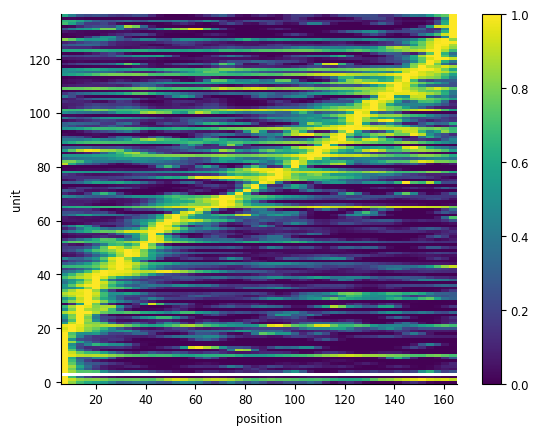

In [72]:
from scipy.ndimage import gaussian_filter1d
# hold out trial from place field computation
run_train = forward_ep.set_diff(ex_run_ep)
# get position of training set
position_train = position.restrict(run_train)
# compute place fields using training set
place_fields = nap.compute_tuning_curves(spikes, position_train, bins=50, feature_names=["position"])
# smooth place fields
place_fields.data = gaussian_filter1d(place_fields.data, 1, axis=-1)

# plot sorted, normalized tuning curves
idx = place_fields.argmax(axis=1)
place_fields_sorted = place_fields.sortby(idx)
place_fields_sorted["unit"] = np.arange(place_fields_sorted.shape[0])
p = (place_fields_sorted / place_fields_sorted.max(axis=1)).plot()

In [73]:
p.figure.savefig("../../_static/_check_figs/pc-14.png")

<div class="render-user">
:::{admonition} Figure check
:class: dropdown
![](../../_static/_check_figs/pc-14.png)
:::
</div>



<div class="render-all">

We can decode any number of features using the function [`nap.decode_bayes`](https://pynapple.org/generated/pynapple.process.decoding.html#pynapple.process.decoding.decode_bayes), which will decode any number of features given by the input `tuning_curves`, computed by [`nap.compute_tuning_curves`](https://pynapple.org/generated/pynapple.process.tuning_curves.html#pynapple.process.tuning_curves.compute_tuning_curves).

#### 5.1 Use [`nap.decode_bayes`](https://pynapple.org/generated/pynapple.process.decoding.html#pynapple.process.decoding.decode_bayes) to decode position during `ex_run_ep`

- Use 40 ms time bins

</div>

<div class="render-user">
```{code-cell} ipython3
decoded_position, decoded_prob = 
```
</div>

In [74]:
decoded_position, decoded_prob = nap.decode_bayes(place_fields, spikes, ex_run_ep, 0.04)

<div class="render-all">

Let's plot decoded position with the animal's true position. We'll overlay them on a heat map of the decoded probability to visualize the confidence of the decoder.

</div>

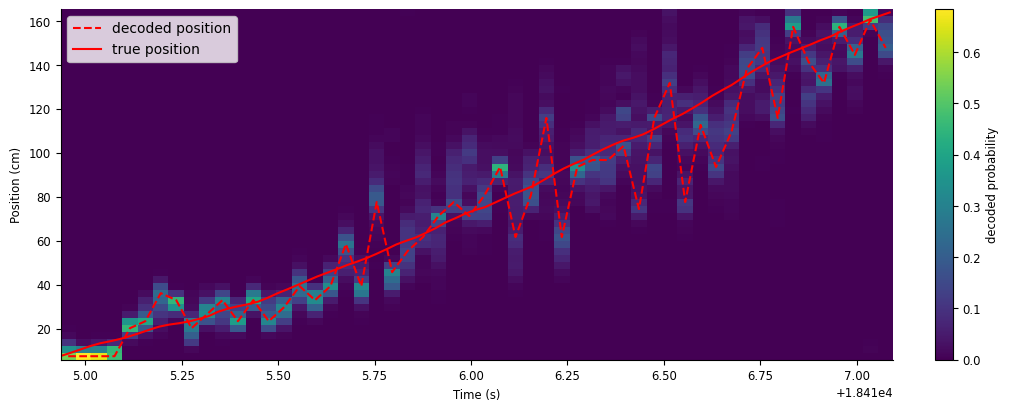

In [75]:
fig,ax = plt.subplots(figsize=(10, 4), constrained_layout=True)
c = ax.pcolormesh(decoded_position.index,place_fields.position,np.transpose(decoded_prob))
ax.plot(decoded_position, "--", color="red", label="decoded position")
ax.plot(ex_position, color="red", label="true position")
ax.legend()
fig.colorbar(c, label="decoded probability")
ax.set(xlabel="Time (s)", ylabel="Position (cm)", );

In [76]:
fig.savefig("../../_static/_check_figs/pc-15.png")

<div class="render-user">
:::{admonition} Figure check
:class: dropdown
![](../../_static/_check_figs/pc-15.png)
:::
</div>


<div class="render-all">
    
While the decoder generally follows the animal's true position, there is still a lot of error in the decoder, especially later in the run. We can improve the decoder error by smoothing the spike counts. [`nap.decode_bayes`](https://pynapple.org/generated/pynapple.process.decoding.html#pynapple.process.decoding.decode_bayes) provides the option to do this for you by specifying `sliding_window_size`, which specifies the width, in number of bins, of a uniform (all ones) kernel to convolve with the spike counts. This is equivalent to applying a moving sum to adjacent bins, where the width of the kernel is the number of adjacent bins being added together. This is equivalent to counting spikes in a *sliding window* that shifts in shorter increments than the window's width, resulting in bins that overlap. This combines the accuracy of using a wider time bin with the temporal resolution of a shorter time bin.

For example, let's say we want a sliding window of $200 ms$ that shifts by $40 ms$. This is equivalent to summing together 5 adjacent $40 ms$ bins, or convolving spike counts in $40 ms$ bins with a length-5 array of ones ($[1, 1, 1, 1, 1]$). Let's visualize this convolution.

</div>

In [77]:
ex_counts = spikes[unit].restrict(ex_run_ep).count(0.04)
workshop_utils.animate_1d_convolution(ex_counts, np.ones(5), tsd_label="original counts", kernel_label="moving sum", conv_label="convolved counts")

<div class="render-all">
    
The count at each time point is computed by convolving the kernel (yellow), centered at that time point, with the original spike counts (blue). For a length-5 kernel of ones, this amounts to summing the counts in the center bin with two bins before and two bins after (shaded green, top). The result is an array of counts smoothed out in time (green, bottom).

</div>

#### 5.2 Decode the same run as above, now using sliding window size of 5 bins.

<div class="render-user">
```{code-cell} ipython3
smth_decoded_position, smth_decoded_prob = 
```
</div>

In [78]:
smth_decoded_position, smth_decoded_prob = nap.decode_bayes(place_fields, spikes, ex_run_ep, bin_size=0.04, sliding_window_size=5)

<div class="render-all">

Let's plot the results.

</div>

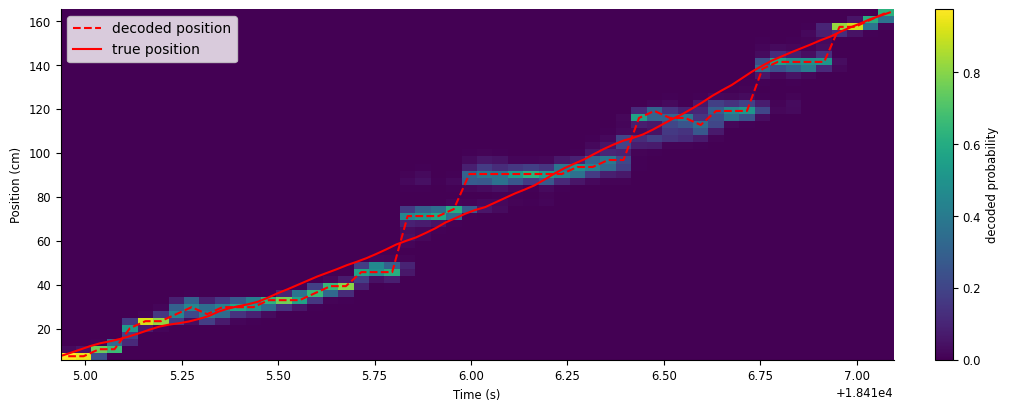

In [79]:
fig,ax = plt.subplots(figsize=(10, 4), constrained_layout=True)
c = ax.pcolormesh(smth_decoded_position.index,place_fields.position,np.transpose(smth_decoded_prob))
ax.plot(smth_decoded_position, "--", color="red", label="decoded position")
ax.plot(ex_position, color="red", label="true position")
ax.legend()
fig.colorbar(c, label="decoded probability")
ax.set(xlabel="Time (s)", ylabel="Position (cm)", );

In [80]:
fig.savefig("../../_static/_check_figs/pc-16.png")

<div class="render-user">
:::{admonition} Figure check
:class: dropdown
![](../../_static/_check_figs/pc-16.png)
:::
</div>

<div class="render-all">
    
This gives us a much closer approximation of the animal's true position.

Units phase precessing together creates fast, spatial sequences around the animal's true position. We can reveal this by decoding at an even shorter time scale, which will appear as smooth errors in the decoder.

</div>

#### 5.3 Decode again using a smaller bin size of $10 ms$ and sliding window size of 5 bins.

<div class="render-user">
```{code-cell} ipython3
smth_decoded_position, smth_decoded_prob = 
```
</div>

In [81]:
smth_decoded_position, smth_decoded_prob = nap.decode_bayes(place_fields, spikes, ex_run_ep, bin_size=0.01, sliding_window_size=5)

<div class="render-all">
    
We'll make the same plot as before to visualize the results, but plot it alongside the raw and filtered LFP.

</div>

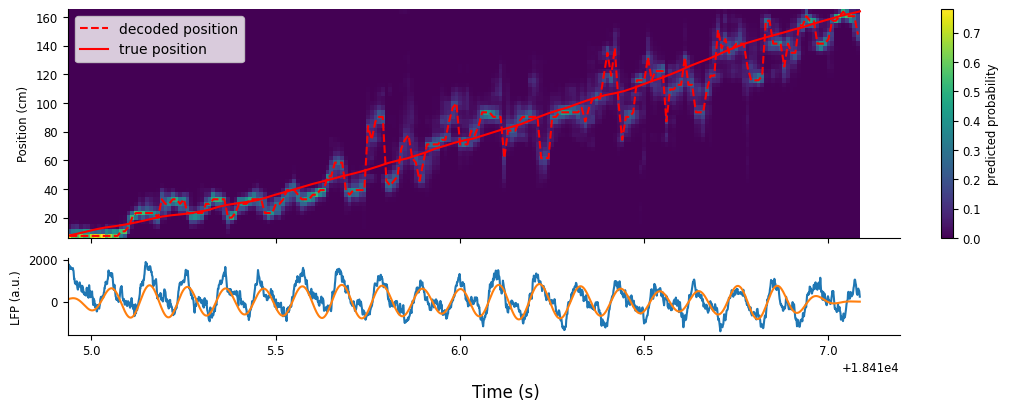

In [82]:
fig, axs = plt.subplots(2, 1, figsize=(10, 4), constrained_layout=True, height_ratios=[3,1], sharex=True)
c = axs[0].pcolormesh(smth_decoded_prob.index, smth_decoded_prob.columns, np.transpose(smth_decoded_prob))
p1 = axs[0].plot(smth_decoded_position, "--", color="r")
p2 = axs[0].plot(ex_position, color="r")
axs[0].set_ylabel("Position (cm)")
axs[0].legend([p1[0],p2[0]],["decoded position","true position"])
fig.colorbar(c, label = "predicted probability")

axs[1].plot(lfp.restrict(ex_run_ep))
axs[1].plot(theta_band.restrict(ex_run_ep))
axs[1].set_ylabel("LFP (a.u.)")

fig.supxlabel("Time (s)");

In [83]:
fig.savefig("../../_static/_check_figs/pc-17.png")

<div class="render-user">
:::{admonition} Figure check
:class: dropdown
![](../../_static/_check_figs/pc-17.png)
:::
</div>

<div class="render-all">
    
The estimated position oscillates with cycles of theta, where each "sweep" is referred to as a "theta sequence". Fully understanding the properties of theta sequences and their role in learning, memory, and planning is an active topic of research in Neuroscience!

</div>

### Bonus Exercise 1

<div class="render-all">
    
Pynapple has another decoding method, [`nap.decode_template`](https://pynapple.org/generated/pynapple.process.decoding.html#pynapple.process.decoding.decode_template), that is agnostic to the underlying noise model of the data. In other words, where the above implementation of Bayesian decoding is specific to spiking data (Poisson distributed data), template decoding can be applied to any data modality. As a bonus exercise, you can try decoding position using this method and compare the results to the Bayesian decoder used above!

</div>

In [84]:
# template decoding

### Bonus Exercise 2

<div class="render-all">
    
Instead of using place fields computed from the data, what if we used the predicted tuning curves by our GLM in Part 2 to do decoding? As a second bonus exercise, you can try Bayesian decoding using GLM-predicted tuning curves and compare the results to the decoding above.

</div>

In [85]:
# GLM decoding

## References

<div class="render-all">

The data in this tutorial comes from [Grosmark, Andres D., and György Buzsáki. "Diversity in neural firing dynamics supports both rigid and learned hippocampal sequences." Science 351.6280 (2016): 1440-1443](https://www.science.org/doi/full/10.1126/science.aad1935).

</div>